# Compulsory Assignment 3: Semantic segmentation

Please fill out the the group name, number, members and optionally the name below.

**Group number**: # \
**Group member 1**:  \
**Group member 2**: \
**Group member 3**: \
**Group name (optional)**: Inserisci qui il nome del tuo gruppo


# Assignment Submission
To complete this assignment answer the relevant questions in this notebook and write the code required to implement the relevant models. This is the biggest assignment of the semester, and therefore you get two weeks to work on it. However, we reccomend that **you start early**. This assignment has three semi-big sections, each of which build upon the last. So if you delay the assignment until the day before submission, you will most likely fail. This assignment is completed by doing the following.
* Submit notebook as an .ipynb file to canvas.
* Submit notebook as an .pdf file to canvas.
* Submit the python script you run on ORION to canvas.
* Submit the SLURM script you run on ORION to canvas.
* Submit at least one of your model predictions to the Kaggle leaderboard, and attain a score that is higher than the *BEAT ME* score.

NOTE: Remember to go through the rules given in the lecture "Introduction to compulsory assignments", as there are many do's and dont's with regard to how you should present the work you are going to submit.


# Introduction
In the context of transportation, pilots need to identify possible urgent landing areas in forests.
Therefore, scientists have provided us with aerial photos of the forest and accompanying image
masks that indicate the presence of birch trees in the images. These masks are binary, with a value of
0 representing areas without birch trees and a value of 1 indicating the presence of birch trees. Our
objective is to utilize this dataset to train a model capable of performing semantic segmentation,
accurately identifying and delineating birch trees in the images.

## Dataset
In this assigmnet you will be given 3200 annotated images. The image, and mask dimensions are 128x128 pixels. With each image there follows an annotation mask where each pixel is classified as `1` (birch tree occurence) or `0` (not birch tree) The test-dataset contains 800 images, where no ground truth masks are given. To evaluate your model on the test dataset, submit your predictions to the Kaggle leaderboard.

## Assignment tasks

1. Familiarising: Before any modelling, visualise examples of the raw data and masks in
your Jupyter notebook.
2. Basic U-NET: Create a U-Net with optional dropout. Use a proportion of the images
for validation when training. The minimum requirement is to tune the following
parameters: number of convolutional filters, dropout and learning rate. Report
strategies and scores leading up to the final choice.
3. I recommend adding augmentation (both images and masks) and changing the loss
function, e.g. implementing F1 loss. Create a plot showing your model's predicted
mask on some images in the training set and compare to the correct mask.
4. Transfer learning: Create a U-Net where the encoder part of the U-Net uses a pretrained VGG16 (or some other similar pre-trained model)
3. This can be achieved by loading a pre-trained model, dropping the final layer and
freezing the weights. Add skip connections from the Conv2D layers of the VGG16-
based encoder to the expansion layers of the decoder.


## Submissions to the Kaggle leaderboard

Link to the Kaggle leaderboard will be posted in the Canvas assignment.

```python
y_pred      = model.predict(X_test)                       # Make prediction
flat_y_pred = y_pred.flatten()                            # Flatten prediction
flat_y_pred[flat_y_pred >= USER_DETERMINED_THRESHOLD] = 1 # Binarize prediction (Optional, depends on output activation used)
flat_y_pred[flat_y_pred != 1]   = 0                       # Binarize prediction (Optional, depends on output activation used)
submissionDF = pd.DataFrame()
submissionDF['ID'] = range(len(flat_y_pred))              # The submission csv file must have a column called 'ID'
submissionDF['Prediction'] = flat_y_pred
submissionDF.to_csv('submission.csv', index=False)        # Remember to store the dataframe to csv without the nameless index column.
```

# Library imports
Feel free to import other packages as needed.

In [3]:
# prompt: mount the google disk

# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# import sys
# sys.path.append('/content/drive/My Drive/CA-3')

In [5]:
# sys.path.append('/content/drive/MyDrive/Colab Notebooks/DAT300/CA3')

In [1]:
import time
from tqdm import tqdm # Cool progress bar
import random
import numpy as np
import pandas as pd
import h5py
import cv2
import re
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
from utilities import *
from visualization import *
SEED = 458 # Feel free to set another seed if you want to
RNG = np.random.default_rng(SEED) # Random number generator
tf.random.set_seed(SEED)

2024-10-23 14:12:48.743915: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-23 14:12:48.960688: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-23 14:12:49.189349: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-23 14:12:49.318185: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-23 14:12:49.351970: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-23 14:12:49.589705: I tensorflow/core/platform/cpu_feature_gu

# Data loading

Load the data from the HDF5 file `tree_train.h5` and `tree_test.h5` that is available on Canvas, and Kaggle.
The data should be loaded in the same manner as in CA2.

In [4]:
with h5py.File("DAT300_Dataset_CA_3/tree_train.h5",'r') as f:
    print('Datasets in file:', list(f.keys()))
    X_train = np.asarray(f['X'])
    y_train = np.asarray(f['y'],dtype=np.float64) # avoid clashing dtype errors
    print('Nr. train images: %i'%(X_train.shape[0]))

print(X_train.shape)
print(y_train.shape)

Datasets in file: ['X', 'y']
Nr. train images: 3200
(3200, 128, 128, 3)
(3200, 128, 128, 1)


In [5]:
with h5py.File("DAT300_Dataset_CA_3/tree_test.h5",'r') as g:
    print('Datasets in file:', list(g.keys()))
    kaggle_data = np.asarray(g['X'])

Datasets in file: ['X']


In [9]:
# with h5py.File("/content/drive/My Drive/CA-3/DAT300_Dataset_CA_3/tree_train.h5",'r') as f:
#     print('Datasets in file:', list(f.keys()))
#     X_train = np.asarray(f['X'])
#     y_train = np.asarray(f['y'],dtype=np.float64) # avoid clashing dtype errors
#     print('Nr. train images: %i'%(X_train.shape[0]))

# print(X_train.shape)
# print(y_train.shape)

In [10]:
# with h5py.File("/content/drive/My Drive/CA-3/DAT300_Dataset_CA_3/tree_test.h5",'r') as g:
#     print('Datasets in file:', list(g.keys()))
#     kaggle_data = np.asarray(g['X'])


# Visualization

Plot a few samples images and masks. \
Feel free to visualize any other aspects of the dataset that you feel are relevant.

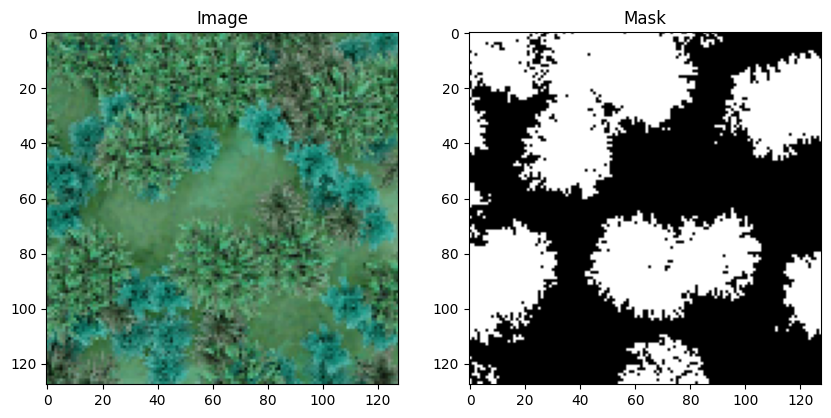

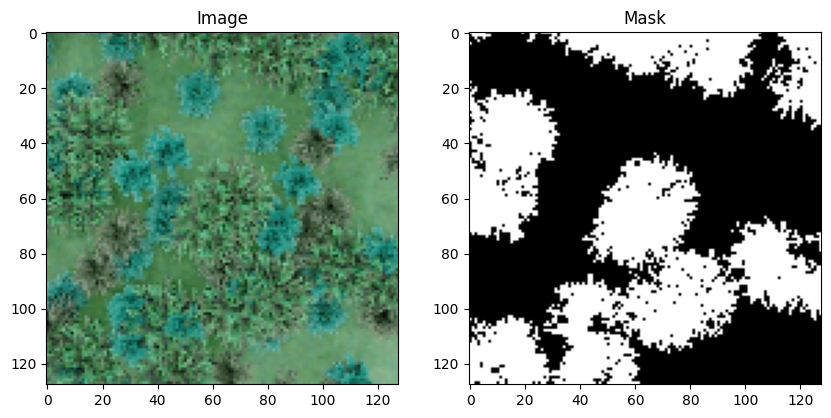

In [6]:
def show_image_and_mask(image_index):
  """Displays an image and its corresponding mask from the training dataset.

  Args:
    image_index: The index of the image to display.
  """
  plt.figure(figsize=(10, 5))

  plt.subplot(1, 2, 1)
  plt.imshow(X_train[image_index])
  plt.title("Image")

  plt.subplot(1, 2, 2)
  plt.imshow(y_train[image_index], cmap='gray')
  plt.title("Mask")

  plt.show()

show_image_and_mask(0)
show_image_and_mask(100)


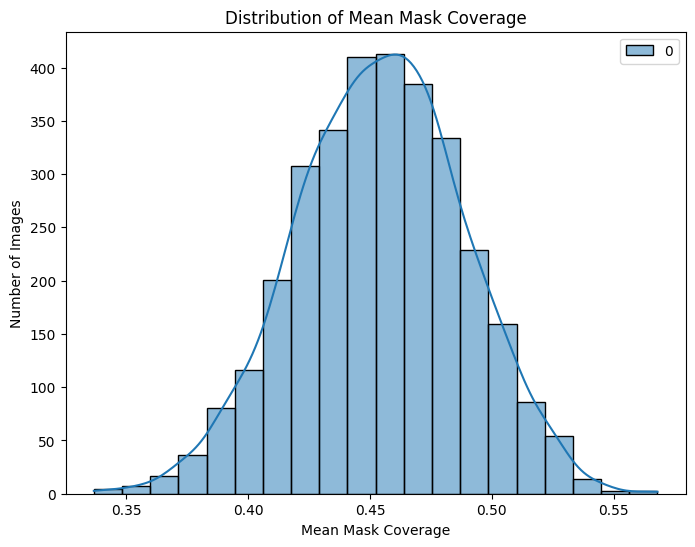

In [7]:
def plot_mask_coverage_distribution(y_train):
  """Plots the distribution of mean mask coverage for all images."""
  mean_coverage = np.mean(y_train, axis=(1, 2))
  plt.figure(figsize=(8, 6))
  sns.histplot(mean_coverage, bins=20, kde=True)
  plt.title("Distribution of Mean Mask Coverage")
  plt.xlabel("Mean Mask Coverage")
  plt.ylabel("Number of Images")
  plt.show()

plot_mask_coverage_distribution(y_train)


# Preprocessing

Preprocess the dataset in whatever ways you think are helpful. \
Tips: Perhaps you preprocess the different models in different ways?

In [8]:
def rescale_images(images):
    """Rescales images to the range [0, 1]."""
    if np.max(images) > 1:
      return images / np.max(images)
    else:
      return images

X_train = rescale_images(X_train)
kaggle_data = rescale_images(kaggle_data)

print(np.max(X_train))
print(np.max(kaggle_data))


1.0
1.0


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED)

In [10]:
# prompt: Create an image generator to modify the input image and mask in the same way

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an image data generator
image_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create a mask data generator (similar to image generator, but no rescaling or featurewise_center)
mask_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Combine generators
def combined_generator(image_generator, mask_generator, X, Y, batch_size):
  genX = image_generator.flow(X, batch_size=batch_size, seed=SEED)
  genY = mask_generator.flow(Y, batch_size=batch_size, seed=SEED)
  for x, y in zip(genX, genY):
    yield x, y

train_generator = combined_generator(image_datagen, mask_datagen, X_train, y_train, batch_size=32)


# Part 1: Implementing U-net

## Intersection over Union

The IoU score is a popular metric in both segmentation and object detection problems.

If you want to use the `plot_training_history` function in the `visualization.py` library remember to compile the model with the TP, TN, FP, FN metrics such that you can estimate the *Intersection-over-Union*. **However, it is voluntary to estimate IoU**

See example below:

```python
from tensorflow.keras.metrics import FalseNegatives, FalsePositives, TrueNegatives, TruePositives
from utilities import F1_score,
from visualization import plot_training_history,
...
model.compile(optimizer='Something',
                  loss='Something else',
                  metrics=[FalseNegatives(),
                           FalsePositives(),
                           TrueNegatives(),
                           TruePositives(),
                           F1_score,
                           OtherMetricOfChoice])

training_history = model.fit(X_train, y_train, ...)
plot_training_history(training_history)
```

You have also been provided with a custom F1-score metric in the `utilities.py` library, which is specific for image segmentation. **This is mandatory to use when compiling the model**.


## Task 1.1 Model implementation

Implement the classical U-net structure that you have learned about in the lectures. Feel free to experiment with the number of layers, loss-function, batch-normalization, etc. **Remember to compile with the F1-score metric**.


### U-net

In [16]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# import true positive, true negative, false positive, false negative
from tensorflow.keras.metrics import TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from tensorflow.keras import backend as K
from sklearn.model_selection import ParameterGrid
from utilities import F1_score
import numpy as np
import time

class UNet:
    def __init__(self, input_shape=(128, 128, 3), num_conv_filters=16, filter_growth_rate=2, dropout_rate=0.0, learning_rate=0.001, activation='relu'):
        self.input_shape = input_shape
        self.num_conv_filters = num_conv_filters
        self.filter_growth_rate = filter_growth_rate
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self.activation = activation

    def build_model(self):
        inputs = Input(shape=self.input_shape)

        # Encoder Block 1
        c1 = Conv2D(self.num_conv_filters, (3, 3), activation=None, padding='same')(inputs)
        c1 = self._apply_activation(c1)
        c1 = BatchNormalization()(c1)
        c1 = Conv2D(self.num_conv_filters, (3, 3), activation=None, padding='same')(c1)
        c1 = self._apply_activation(c1)
        c1 = BatchNormalization()(c1)
        p1 = MaxPooling2D((2, 2))(c1)
        if self.dropout_rate > 0:
            p1 = Dropout(self.dropout_rate)(p1)

        # Encoder Block 2
        c2 = Conv2D(self.num_conv_filters * self.filter_growth_rate, (3, 3), activation=None, padding='same')(p1)
        c2 = self._apply_activation(c2)
        c2 = BatchNormalization()(c2)
        c2 = Conv2D(self.num_conv_filters * self.filter_growth_rate, (3, 3), activation=None, padding='same')(c2)
        c2 = self._apply_activation(c2)
        c2 = BatchNormalization()(c2)
        p2 = MaxPooling2D((2, 2))(c2)
        if self.dropout_rate > 0:
            p2 = Dropout(self.dropout_rate)(p2)

        # Bottleneck
        c3 = Conv2D(self.num_conv_filters * self.filter_growth_rate * 2, (3, 3), activation=None, padding='same')(p2)
        c3 = self._apply_activation(c3)
        c3 = BatchNormalization()(c3)
        c3 = Conv2D(self.num_conv_filters * self.filter_growth_rate * 2, (3, 3), activation=None, padding='same')(c3)
        c3 = self._apply_activation(c3)
        c3 = BatchNormalization()(c3)

        # Decoder Block 1
        u4 = UpSampling2D((2, 2))(c3)
        u4 = concatenate([u4, c2])
        c4 = Conv2D(self.num_conv_filters * self.filter_growth_rate, (3, 3), activation=None, padding='same')(u4)
        c4 = self._apply_activation(c4)
        c4 = BatchNormalization()(c4)
        c4 = Conv2D(self.num_conv_filters * self.filter_growth_rate, (3, 3), activation=None, padding='same')(c4)
        c4 = self._apply_activation(c4)
        c4 = BatchNormalization()(c4)

        # Decoder Block 2
        u5 = UpSampling2D((2, 2))(c4)
        u5 = concatenate([u5, c1])
        c5 = Conv2D(self.num_conv_filters, (3, 3), activation=None, padding='same')(u5)
        c5 = self._apply_activation(c5)
        c5 = BatchNormalization()(c5)
        c5 = Conv2D(self.num_conv_filters, (3, 3), activation=None, padding='same')(c5)
        c5 = self._apply_activation(c5)
        c5 = BatchNormalization()(c5)

        # Output Layer
        outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)

        # Compile Model
        model = Model(inputs=[inputs], outputs=[outputs])
        model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss="binary_crossentropy", metrics=[F1_score,
                                                                                                            TruePositives(),
                                                                                                            TrueNegatives(),
                                                                                                            FalsePositives(),
                                                                                                            FalseNegatives()
                                                                                                          ])
        return model

    def _apply_activation(self, x):
        if self.activation == 'relu':
            return LeakyReLU(alpha=0.1)(x)
        else:
            return x  # Default to relu, but more options can be added here

    def combined_loss(self, y_true, y_pred):
        return self.dice_loss(y_true, y_pred) + K.binary_crossentropy(y_true, y_pred)

    def dice_loss(self, y_true, y_pred):
        smooth = 1.0
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def train_model(self, X_train, y_train, X_val, y_val, batch_size=32, epochs=50):
        model = self.build_model()
        early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
        model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)
        reduce_lr = ReduceLROnPlateau(factor=0.1, patience=3)

        history = model.fit(X_train, y_train,
                            validation_data=(X_val, y_val),
                            batch_size=batch_size, epochs=epochs,
                            callbacks=[early_stopping, model_checkpoint, reduce_lr])
        return model, history
    
    def train_model_with_generator(self, train_generator, X_val, y_val, batch_size=32, epochs=50, steps_per_epoch=100):
        model = self.build_model()
        early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
        model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)
        reduce_lr = ReduceLROnPlateau(factor=0.1, patience=3)

        history = model.fit(train_generator,
                            validation_data=(X_val, y_val),
                            steps_per_epoch=steps_per_epoch,
                            batch_size=batch_size, epochs=epochs,
                            callbacks=[early_stopping, model_checkpoint, reduce_lr])
        return model, history

In [17]:
def perform_hyperparameter_search(X_train, y_train, X_val, y_val):
    # Define the hyperparameter grid
    param_grid = {
        'num_conv_filters': [16, 32],
        'filter_growth_rate': [2, 4],
        'dropout_rate': [0.5, 0.6],
        'learning_rate': [0.0001, 0.0005],
        'activation': ['relu']
    }

    param_combinations = list(ParameterGrid(param_grid))
    results = []

    # Time constraint: limit model search to approximately 1 hour
    start_time = time.time()
    time_limit = 3600  # One hour in seconds

    for params in param_combinations:
        if time.time() - start_time > time_limit:
            break  # Stop if time limit is reached

        print(f"Testing parameters: {params}")
        unet = UNet(
            input_shape=(128, 128, 3),
            num_conv_filters=params['num_conv_filters'],
            filter_growth_rate=params['filter_growth_rate'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate'],
            activation=params['activation']
        )

        model, history = unet.train_model(X_train, y_train, X_val, y_val, batch_size=32, epochs=15)
        results.append((params, history.history))

    return results

In [18]:
results = perform_hyperparameter_search(X_train, y_train, X_val, y_val)

Testing parameters: {'activation': 'relu', 'dropout_rate': 0.5, 'filter_growth_rate': 2, 'learning_rate': 0.0001, 'num_conv_filters': 16}


/home/tycho/DAT300/.venv/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/15


I0000 00:00:1729435713.330694    2906 service.cc:146] XLA service 0x7f0e14067230 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729435713.330765    2906 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-10-20 16:48:33.500148: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-20 16:48:34.001890: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 3/80 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - f1_score: 0.5049 - false_negatives: 217296.3281 - false_positives: 283958.0000 - loss: 0.8164 - true_negatives: 290120.3438 - true_positives: 257201.3281 

I0000 00:00:1729435721.861624    2906 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


80/80 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - f1_score: 0.6612 - false_negatives: 2597758.2500 - false_positives: 3495616.0000 - loss: 0.6055 - true_negatives: 8258556.0000 - true_positives: 7137405.0000 - val_f1_score: 5.5705e-05 - val_false_negatives: 4773787.0000 - val_false_positives: 53.0000 - val_loss: 0.9782 - val_true_negatives: 5711787.0000 - val_true_positives: 133.0000 - learning_rate: 1.0000e-04
Epoch 2/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - f1_score: 0.8516 - false_negatives: 1257672.3750 - false_positives: 1635337.2500 - loss: 0.3302 - true_negatives: 10118835.0000 - true_positives: 8477491.0000 - val_f1_score: 4.9467e-05 - val_false_negatives: 4773802.0000 - val_false_positives: 39.0000 - val_loss: 1.2086 - val_true_negatives: 5711801.0000 - val_true_positives: 118.0000 - learning_rate: 1.0000e-04
Epoch 3/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - f1_score: 0.8726 - false_negatives: 1102998.7500 - false_positives: 1394142.1250 - loss: 0.2889 - true_negatives: 103600

Testing parameters: {'activation': 'relu', 'dropout_rate': 0.5, 'filter_growth_rate': 4, 'learning_rate': 0.0005, 'num_conv_filters': 32}

95% ish




## Task 1.2 Train the model, and plot the training history
Feel free to use the `plot_training_history` function from the provided library `utilities.py`

### Training the model

In [19]:
# prompt: train the model using the model and training generator

# Train the model
network = UNet(input_shape=(128, 128, 3), num_conv_filters=48, filter_growth_rate=4, dropout_rate=0.5, learning_rate=0.0005, activation='relu')

model, history = network.train_model_with_generator(train_generator, X_val, y_val, batch_size=32, epochs=25, steps_per_epoch=100)


Epoch 1/25


2024-10-20 17:06:13.728429: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 13.82GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-10-20 17:06:17.417113: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng1{k2=6,k3=0} for conv (f32[192,576,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,576,64,64]{3,2,1,0}, f32[32,192,64,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-10-20 17:06:17.508041: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The oper

100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 141ms/step - f1_score: 0.7975 - false_negatives_16: 2715653.2500 - false_positives_16: 962060.9375 - loss: 0.3739 - true_negatives_16: 11564624.0000 - true_positives_16: 11491159.0000 - val_f1_score: 0.0000e+00 - val_false_negatives_16: 4773920.0000 - val_false_positives_16: 0.0000e+00 - val_loss: 0.7358 - val_true_negatives_16: 5711840.0000 - val_true_positives_16: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - f1_score: 0.8822 - false_negatives_16: 2205025.5000 - false_positives_16: 306448.6562 - loss: 0.2146 - true_negatives_16: 12186133.0000 - true_positives_16: 12035890.0000 - val_f1_score: 0.0000e+00 - val_false_negatives_16: 4773920.0000 - val_false_positives_16: 0.0000e+00 - val_loss: 1.2628 - val_true_negatives_16: 5711840.0000 - val_true_positives_16: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 122ms/step - f1_score: 0.8894 - false_negatives_16: 2152065.500

### Plotting performance

In [20]:
print(history.history.keys())


dict_keys(['f1_score', 'false_negatives_16', 'false_positives_16', 'loss', 'true_negatives_16', 'true_positives_16', 'val_f1_score', 'val_false_negatives_16', 'val_false_positives_16', 'val_loss', 'val_true_negatives_16', 'val_true_positives_16', 'learning_rate'])


In [21]:
def plot_training_history(training_history_object, list_of_metrics=['Accuracy', 'F1_score', 'IoU'], start_epoch=0):
    """
    Description: This is meant to be used in interactive notebooks.
    Input:
        training_history_object:: training history object returned from 
                                  tf.keras.model.fit()
        list_of_metrics        :: Can be any combination of the following options 
                                  ('Loss', 'Precision', 'Recall', 'F1_score', 'IoU'). 
                                  Generates one subplot per metric, where training 
                                  and validation metric is plotted.
        start_epoch            :: Plot metrics starting from this epoch (default: 0).
    Output:
    """
    rawDF = pd.DataFrame(training_history_object.history)
    plotDF = pd.DataFrame()

    # Extract the suffix (e.g., '_5') from one of the metric keys
    suffix = ''
    for key in rawDF.columns:
        if key.startswith('true_positives'):
            suffix = key[len('true_positives'):]
            break

    # Calculate Accuracy (TP + TN) / (TP + TN + FP + FN) if metrics are present
    if all(metric + suffix in rawDF.columns for metric in ['true_positives', 'true_negatives', 'false_positives', 'false_negatives']):
        plotDF['Accuracy'] = (rawDF['true_positives' + suffix] + rawDF['true_negatives' + suffix]) / \
                             (rawDF['true_positives' + suffix] + rawDF['true_negatives' + suffix] + rawDF['false_positives' + suffix] + rawDF['false_negatives' + suffix])
        plotDF['val_Accuracy'] = (rawDF['val_true_positives' + suffix] + rawDF['val_true_negatives' + suffix]) / \
                                 (rawDF['val_true_positives' + suffix] + rawDF['val_true_negatives' + suffix] + rawDF['val_false_positives' + suffix] + rawDF['val_false_negatives' + suffix])

    # Calculate IoU (TP) / (TP + FP + FN)
    if all(metric + suffix in rawDF.columns for metric in ['true_positives', 'false_positives', 'false_negatives']):
        plotDF['IoU'] = rawDF['true_positives' + suffix] / \
                        (rawDF['true_positives' + suffix] + rawDF['false_positives' + suffix] + rawDF['false_negatives' + suffix])
        plotDF['val_IoU'] = rawDF['val_true_positives' + suffix] / \
                            (rawDF['val_true_positives' + suffix] + rawDF['val_false_positives' + suffix] + rawDF['val_false_negatives' + suffix])

    # Add F1 score directly (custom metric)
    if 'f1_score' in rawDF.columns:
        plotDF['F1_score'] = rawDF['f1_score']
    if 'val_f1_score' in rawDF.columns:
        plotDF['val_F1_score'] = rawDF['val_f1_score']

    # Filter data to plot only after the specified start_epoch
    plotDF = plotDF.iloc[start_epoch:]
    
    # Plotting the requested metrics
    train_keys = list_of_metrics
    valid_keys = ['val_' + key for key in list_of_metrics]
    nr_plots = len(list_of_metrics)

    fig, ax = plt.subplots(1, nr_plots, figsize=(5 * nr_plots, 4))

    for i in range(len(list_of_metrics)):
        metric = list_of_metrics[i]
        if metric in plotDF.columns and 'val_' + metric in plotDF.columns:
            ax[i].plot(np.array(plotDF[train_keys[i]]), label='Training')
            ax[i].plot(np.array(plotDF[valid_keys[i]]), label='Validation')
            ax[i].set_xlabel('Epoch')
            ax[i].set_title(metric)
            ax[i].grid(True)
            ax[i].legend()
        else:
            print(f"Metric '{metric}' not found in history. Skipping...")
    
    fig.tight_layout()
    plt.show()


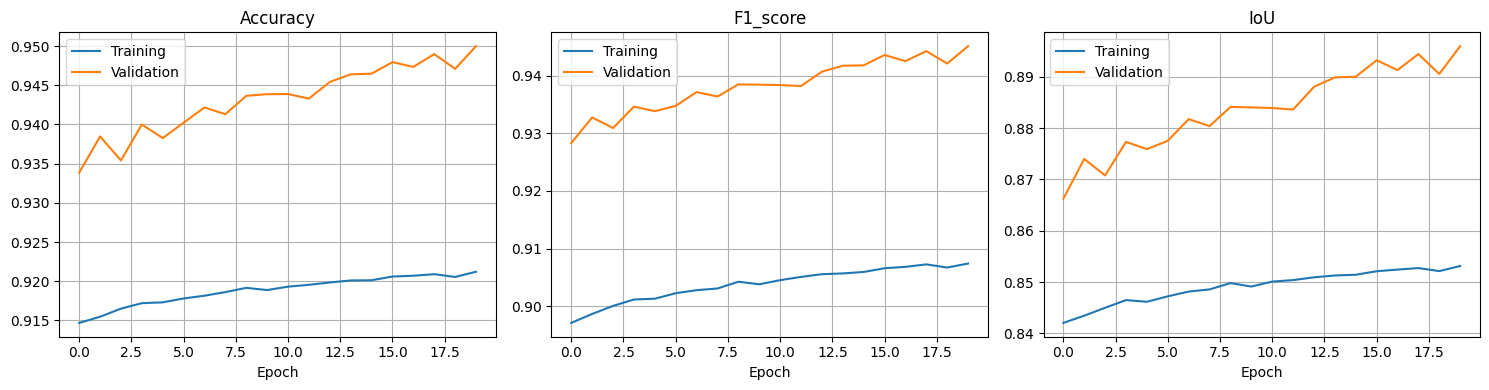

In [22]:
plot_training_history(history, list_of_metrics=['Accuracy', 'F1_score', 'IoU'], start_epoch=5)


## Task 1.3 Visualize model predictions

Make a plot that illustrates the original image, the predicted mask, and the ground truth mask.

### Plotting

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


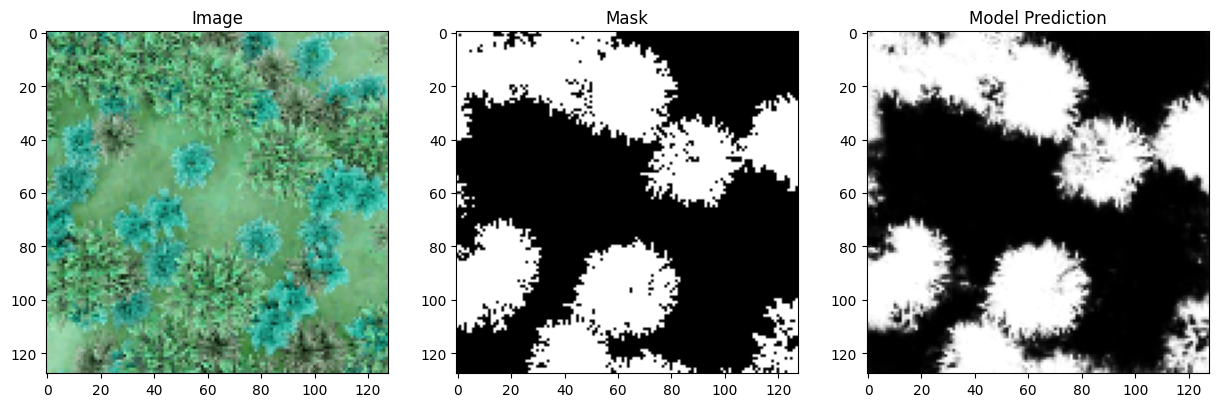

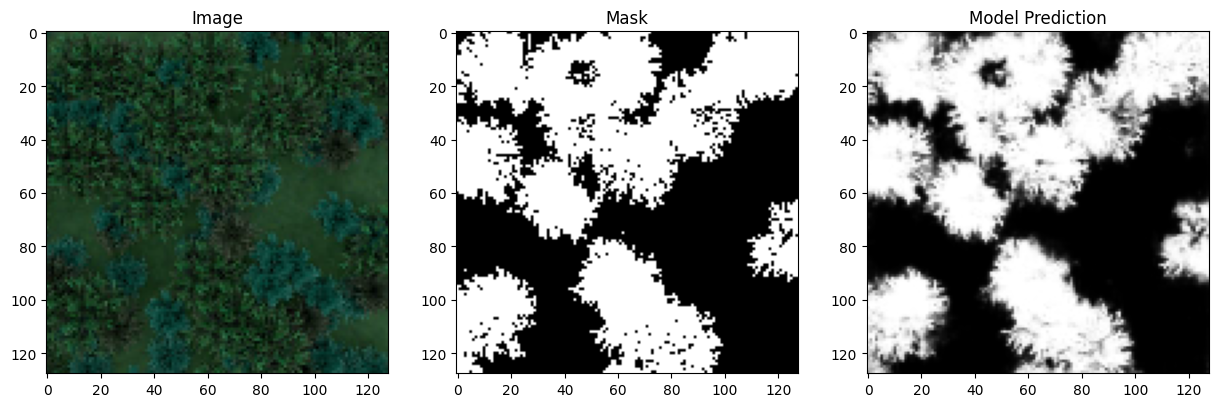

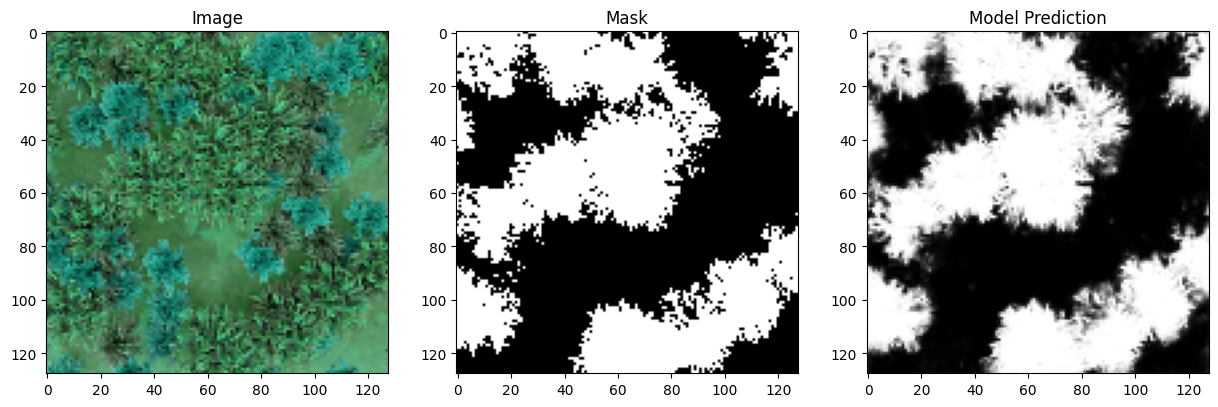

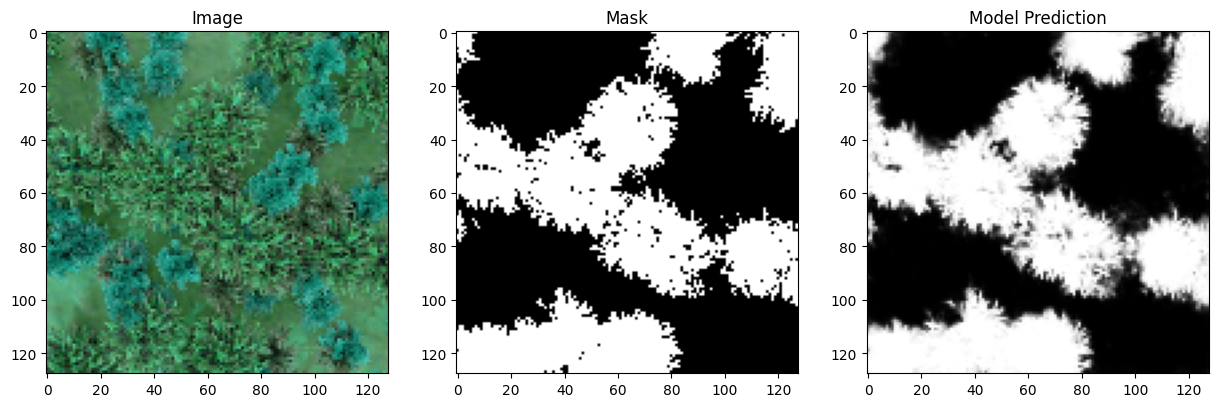

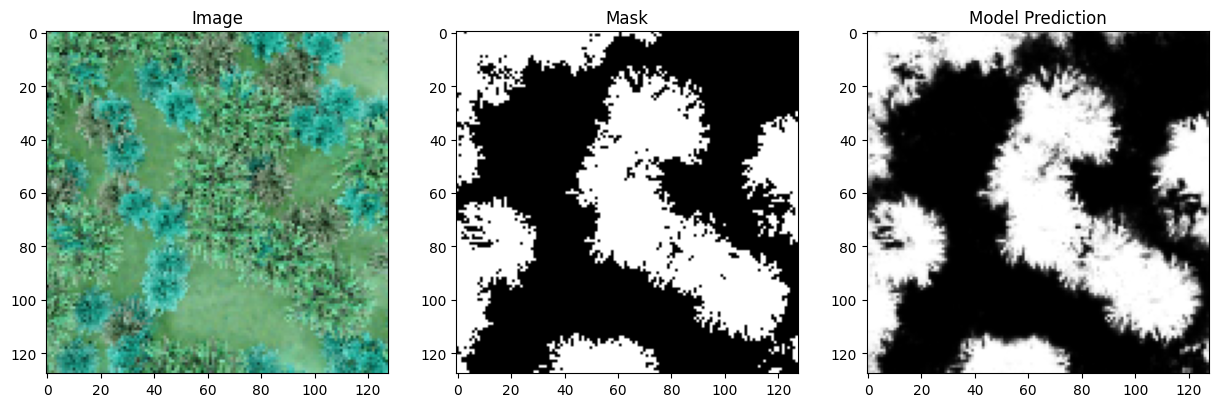

In [23]:
# We want to plot the output of the model on the test data

def plot_predictions(model, X, y, num_images=5):
    """Plots the model's predictions alongside the original images and masks."""
    predictions = model.predict(X[:num_images])
    for i in range(num_images):
        plt.figure(figsize=(15, 10))

        plt.subplot(1, 3, 1)
        plt.imshow(X[i])
        plt.title("Image")

        plt.subplot(1, 3, 2)
        plt.imshow(y[i], cmap='gray')
        plt.title("Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title("Model Prediction")

        plt.show()

plot_predictions(model, X_val, y_val, num_images=5)

# Part 2: Implementing U-net with transfer learning

Implement a model with the U-net structure that you have learned about in the lectures, but now with a pre-trained backbone. There are many pre-trained back-bones to choose from. Pick freely from the selection here [tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications), or here [Keras model scores](https://keras.io/api/applications/) (nicer table in the second link). Feel free to experiment with the number of layers, loss-function, batch-normalization, etc. Many of the backbones available are quite big, so you might find it quite time-consuming to train them on your personal computers. It might be expedient to only train them for 1-5 epochs on your PCs, and do the full training on Orion in Part 3.


#### For those with a dedicated graphics card (NVIDIA and AMD) Tensorflow or PyTorch (not syllabus)
And wants to experiment with their own compute resources (can be alot of fun)\
Tensorflow: https://learn.microsoft.com/en-us/windows/ai/directml/gpu-tensorflow-plugin \
PyTorch: https://learn.microsoft.com/en-us/windows/ai/directml/pytorch-windows

## Task 2.1 Transfer learning model implementation

Implement a U-net model utilizing the pre-trained weights of a publically available network. **Remember to compile with the F1-score metric**.

### Transfer learning with U-net

In [23]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, UpSampling2D, Dropout, ReLU, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.metrics import TruePositives, TrueNegatives, FalsePositives, FalseNegatives


# Input size
input_shape = (128, 128, 3)
num_conv_filters = 64  # Example filter size
filter_growth_rate = 2  # Example growth rate
dropout_rate = 0.5  # Dropout rate

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Concatenate, BatchNormalization, ReLU, Dropout
from tensorflow.keras.models import Model

def build_resnet50_unet(input_shape, num_conv_filters=64, filter_growth_rate=1, dropout_rate=0.3):
    # Input layer
    inputs = Input(shape=input_shape)

    # Load the ResNet50 model without the fully connected layers and with pretrained ImageNet weights
    resnet_encoder = ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')

    # Extract feature maps from specific layers of ResNet50
    # These are the skip connection layers
    skip1 = resnet_encoder.get_layer('conv1_relu').output  # Shape: (64, 64, 64)
    skip2 = resnet_encoder.get_layer('conv2_block3_out').output  # Shape: (32, 32, 256)
    skip3 = resnet_encoder.get_layer('conv3_block4_out').output  # Shape: (16, 16, 512)
    skip4 = resnet_encoder.get_layer('conv4_block6_out').output  # Shape: (8, 8, 1024)

    # Bottleneck (deepest layer from ResNet50)
    bottleneck = resnet_encoder.get_layer('conv5_block3_out').output  # Shape: (4, 4, 2048)

    # Bottleneck Conv layers
    c3 = Conv2D(num_conv_filters * filter_growth_rate * 2, (3, 3), padding='same')(bottleneck)
    c3 = ReLU()(c3)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(num_conv_filters * filter_growth_rate * 2, (3, 3), padding='same')(c3)
    c3 = ReLU()(c3)
    c3 = BatchNormalization()(c3)

    # Decoder Block 1: Upsample from (4,4) -> (8,8), skip connection from skip4
    u4 = UpSampling2D((2, 2))(c3)
    u4 = Concatenate()([u4, skip4])  # Add skip connection
    u4 = Conv2D(num_conv_filters * filter_growth_rate * 2, (3, 3), padding='same')(u4)
    u4 = ReLU()(u4)
    u4 = BatchNormalization()(u4)

    # Decoder Block 2: Upsample from (8,8) -> (16,16), skip connection from skip3
    u5 = UpSampling2D((2, 2))(u4)
    u5 = Concatenate()([u5, skip3])  # Add skip connection
    u5 = Conv2D(num_conv_filters * filter_growth_rate * 2, (3, 3), padding='same')(u5)
    u5 = ReLU()(u5)
    u5 = BatchNormalization()(u5)

    # Decoder Block 3: Upsample from (16,16) -> (32,32), skip connection from skip2
    u6 = UpSampling2D((2, 2))(u5)
    u6 = Concatenate()([u6, skip2])  # Add skip connection
    u6 = Conv2D(num_conv_filters * filter_growth_rate, (3, 3), padding='same')(u6)
    u6 = ReLU()(u6)
    u6 = BatchNormalization()(u6)

    # Decoder Block 4: Upsample from (32,32) -> (64,64), skip connection from skip1
    u7 = UpSampling2D((2, 2))(u6)
    u7 = Concatenate()([u7, skip1])  # Add skip connection
    u7 = Conv2D(num_conv_filters, (3, 3), padding='same')(u7)
    u7 = ReLU()(u7)
    u7 = BatchNormalization()(u7)

    # Decoder Block 5: Upsample from (64,64) -> (128,128)
    u8 = UpSampling2D((2, 2))(u7)
    u8 = Conv2D(num_conv_filters, (3, 3), padding='same')(u8)
    u8 = ReLU()(u8)
    u8 = BatchNormalization()(u8)

    # Apply Dropout if needed
    if dropout_rate > 0:
        u8 = Dropout(dropout_rate)(u8)

    # Final output layer (1-channel output for binary segmentation)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(u8)

    # Build the final model
    model = Model(inputs, outputs)

    return model




# Build the model
model = build_model(input_shape)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', F1_score, TruePositives(), TrueNegatives(), FalsePositives(), FalseNegatives()])

model.summary()


0 input_layer_13
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_bloc

ValueError: No such layer: block_1_expand_relu. Existing layers are: ['input_layer_13', 'conv1_pad', 'conv1_conv', 'conv1_bn', 'conv1_relu', 'pool1_pad', 'pool1_pool', 'conv2_block1_1_conv', 'conv2_block1_1_bn', 'conv2_block1_1_relu', 'conv2_block1_2_conv', 'conv2_block1_2_bn', 'conv2_block1_2_relu', 'conv2_block1_0_conv', 'conv2_block1_3_conv', 'conv2_block1_0_bn', 'conv2_block1_3_bn', 'conv2_block1_add', 'conv2_block1_out', 'conv2_block2_1_conv', 'conv2_block2_1_bn', 'conv2_block2_1_relu', 'conv2_block2_2_conv', 'conv2_block2_2_bn', 'conv2_block2_2_relu', 'conv2_block2_3_conv', 'conv2_block2_3_bn', 'conv2_block2_add', 'conv2_block2_out', 'conv2_block3_1_conv', 'conv2_block3_1_bn', 'conv2_block3_1_relu', 'conv2_block3_2_conv', 'conv2_block3_2_bn', 'conv2_block3_2_relu', 'conv2_block3_3_conv', 'conv2_block3_3_bn', 'conv2_block3_add', 'conv2_block3_out', 'conv3_block1_1_conv', 'conv3_block1_1_bn', 'conv3_block1_1_relu', 'conv3_block1_2_conv', 'conv3_block1_2_bn', 'conv3_block1_2_relu', 'conv3_block1_0_conv', 'conv3_block1_3_conv', 'conv3_block1_0_bn', 'conv3_block1_3_bn', 'conv3_block1_add', 'conv3_block1_out', 'conv3_block2_1_conv', 'conv3_block2_1_bn', 'conv3_block2_1_relu', 'conv3_block2_2_conv', 'conv3_block2_2_bn', 'conv3_block2_2_relu', 'conv3_block2_3_conv', 'conv3_block2_3_bn', 'conv3_block2_add', 'conv3_block2_out', 'conv3_block3_1_conv', 'conv3_block3_1_bn', 'conv3_block3_1_relu', 'conv3_block3_2_conv', 'conv3_block3_2_bn', 'conv3_block3_2_relu', 'conv3_block3_3_conv', 'conv3_block3_3_bn', 'conv3_block3_add', 'conv3_block3_out', 'conv3_block4_1_conv', 'conv3_block4_1_bn', 'conv3_block4_1_relu', 'conv3_block4_2_conv', 'conv3_block4_2_bn', 'conv3_block4_2_relu', 'conv3_block4_3_conv', 'conv3_block4_3_bn', 'conv3_block4_add', 'conv3_block4_out', 'conv4_block1_1_conv', 'conv4_block1_1_bn', 'conv4_block1_1_relu', 'conv4_block1_2_conv', 'conv4_block1_2_bn', 'conv4_block1_2_relu', 'conv4_block1_0_conv', 'conv4_block1_3_conv', 'conv4_block1_0_bn', 'conv4_block1_3_bn', 'conv4_block1_add', 'conv4_block1_out', 'conv4_block2_1_conv', 'conv4_block2_1_bn', 'conv4_block2_1_relu', 'conv4_block2_2_conv', 'conv4_block2_2_bn', 'conv4_block2_2_relu', 'conv4_block2_3_conv', 'conv4_block2_3_bn', 'conv4_block2_add', 'conv4_block2_out', 'conv4_block3_1_conv', 'conv4_block3_1_bn', 'conv4_block3_1_relu', 'conv4_block3_2_conv', 'conv4_block3_2_bn', 'conv4_block3_2_relu', 'conv4_block3_3_conv', 'conv4_block3_3_bn', 'conv4_block3_add', 'conv4_block3_out', 'conv4_block4_1_conv', 'conv4_block4_1_bn', 'conv4_block4_1_relu', 'conv4_block4_2_conv', 'conv4_block4_2_bn', 'conv4_block4_2_relu', 'conv4_block4_3_conv', 'conv4_block4_3_bn', 'conv4_block4_add', 'conv4_block4_out', 'conv4_block5_1_conv', 'conv4_block5_1_bn', 'conv4_block5_1_relu', 'conv4_block5_2_conv', 'conv4_block5_2_bn', 'conv4_block5_2_relu', 'conv4_block5_3_conv', 'conv4_block5_3_bn', 'conv4_block5_add', 'conv4_block5_out', 'conv4_block6_1_conv', 'conv4_block6_1_bn', 'conv4_block6_1_relu', 'conv4_block6_2_conv', 'conv4_block6_2_bn', 'conv4_block6_2_relu', 'conv4_block6_3_conv', 'conv4_block6_3_bn', 'conv4_block6_add', 'conv4_block6_out', 'conv5_block1_1_conv', 'conv5_block1_1_bn', 'conv5_block1_1_relu', 'conv5_block1_2_conv', 'conv5_block1_2_bn', 'conv5_block1_2_relu', 'conv5_block1_0_conv', 'conv5_block1_3_conv', 'conv5_block1_0_bn', 'conv5_block1_3_bn', 'conv5_block1_add', 'conv5_block1_out', 'conv5_block2_1_conv', 'conv5_block2_1_bn', 'conv5_block2_1_relu', 'conv5_block2_2_conv', 'conv5_block2_2_bn', 'conv5_block2_2_relu', 'conv5_block2_3_conv', 'conv5_block2_3_bn', 'conv5_block2_add', 'conv5_block2_out', 'conv5_block3_1_conv', 'conv5_block3_1_bn', 'conv5_block3_1_relu', 'conv5_block3_2_conv', 'conv5_block3_2_bn', 'conv5_block3_2_relu', 'conv5_block3_3_conv', 'conv5_block3_3_bn', 'conv5_block3_add', 'conv5_block3_out'].

## Task 2.2 Train the transfer learning model and plot the training history

Feel free to use the `plot_training_history` function from the provided library `utilities.py`

### Training

In [15]:
history = model.fit(train_generator,
                    validation_data=(X_val, y_val),
                    steps_per_epoch=100,
                    batch_size=32,
                    epochs=50)

Epoch 1/50


KeyError: 'Exception encountered when calling Functional.call().\n\n\x1b[1m140129151039616\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=tf.Tensor(shape=(None, 128, 128, 3), dtype=float32)\n  • training=True\n  • mask=None'

### Plotting

# Part 3: Training your model Orion

Use the lecture slides from the Orion-lecture to get started.
1. Put one of your model implementations into a python script (`.py`)
2. Transfer that script to Orion.
3. Change the relevant path variables in your python script (path-to-data for example), and make sure that you record the time it takes to train the model in the script. This can be done using the `time` library for example.
4. Set up a SLURM-script to train your model, please use the example from the Orion lecture as a base.
5. Submit your SLURM job, and let the magic happen.

If you wish to use a model trained on Orion to make a Kaggle submission, remember to save the model, such that you can transfer it to your local computer to make a prediction on `X_test`, or test the model on Orion directly if you want to.

## Tips

If you compiled, trained and stored a model on Orion with a custom performance metric (such as F1-score), remember to specify that metric when loading the model on your computer again.

Loading a saved model:
```python
trained_model = tf.keras.models.load_model('some/path/to/my_trained_model.keras', custom_objects={'F1_score': F1_score})
```

Loading a checkpoint:
```python
trained_model = tf.keras.saving.load_model('some/path/to/my_trained_model_checkpoint', custom_objects={'F1_score': F1_score})
```

# Discussion

**Question 1: Which model architectures did you explore, and what type of hyperparameter optimization did you try?**

**Answer 1:**

**Question 2: Which of the model(s) did you choose to train on Orion, and how long did it take to train it on Orion?**

**Answer 2:**

**Question 3: What where the biggest challenges with this assignment?**

**Answer 3:**


# Kaggle submission

Evaluate your best model on the test dataset and submit your prediction to the Kaggle leaderboard.
Link to the Kaggle leaderboard will be posted in the Canvas assignment.

### Kaggle submission

In [ ]:
# Threshold for sigmoid
USER_DETERMINED_THRESHOLD = 0.5

y_pred      = model_mobilenet.predict(X_test_mobilenet)  # Make prediction using the trained model
flat_y_pred = y_pred.flatten()                             # Flatten prediction
flat_y_pred[flat_y_pred >= USER_DETERMINED_THRESHOLD] = 1  # Binarize prediction (Optional, depends on output activation used)
flat_y_pred[flat_y_pred != 1]   = 0                        # Binarize prediction (Optional, depends on output activation used)
submissionDF = pd.DataFrame()
submissionDF['ID'] = range(len(flat_y_pred))               # The submission csv file must have a column called 'ID'
submissionDF['Prediction'] = flat_y_pred
submissionDF.to_csv('submission.csv', index=False) # Remember to store the dataframe to csv without the nameless index column.

32/32 [==============================] - 1s 10ms/step


# Appendix
Links to fun and interessting learning resources \
(not so much for this compulsary assignment, more for your own learning and interests):

- <a href="https://streamlit.io/">Streamlit</a>
- <a href="https://github.com/mlabonne/llm-datasets?tab=readme-ov-file">LLM-datasets</a>
- <a href="https://github.com/PacktPublishing/Hands-On-Graph-Neural-Networks-Using-Python">Hands-On Graph Neural Networks Using Python</a>
- <a href="https://github.com/mlabonne/llm-course">LLM Course</a>
- <a href="https://bbycroft.net/llm">LLM by Bycroft</a>
- <a href="https://groq.com/">Groq</a>
- <a href="https://unstructured.io/?fob=kxzdntwfMj4TVNSV">Unstructured.io</a>
- <a href="https://colab.research.google.com/notebooks/tpu.ipynb#scrollTo=a_rjVo-RAoYd">Google Colab TPU Notebook</a>
- <a href="https://github.com/langchain-ai/langgraph/tree/main">LangGraph RAG Agent Llama3 Local</a>
- <a href="https://python.langchain.com/docs/how_to/">LangChain Python Docs</a>
- <a href="https://www.nomic.ai/blog/posts/nomic-embed-text-v1">Nomic Embed Text v1</a>
- <a href="https://duckdb.org/docs/api/python/overview.html">DuckDB Python API Overview</a>
- <a href="https://jsoncrack.com/editor">JSON Crack Editor</a>
- <a href="https://learn.microsoft.com/en-us/azure/data-factory/transform-data-machine-learning-service">Azure Data Factory Machine Learning Service</a>

- <a href="https://learn.microsoft.com/en-us/azure/databricks/machine-learning/">Azure Databricks Machine Learning</a>
- <a href="https://github.com/katanaml">Katana ML - Machine Learning for Business Automation</a>
- <a href="https://deckgl.readthedocs.io/en/latest/">Pydeck - High-scale spatial rendering in Python, powered by deck.gl</a>




